In [1]:
import os
import scipy.io
import numpy as np
from numpy.linalg import norm
from scipy.spatial import distance
d=5000
## please download the data file from the following link: https://drive.google.com/file/d/1x1g4rA5dOoZ0NIaANwHlWseVIAM8ztHr/
mat = scipy.io.loadmat('Data/Text/DATA_EXAMPLE_PIPELINE_HD_10000_3.mat')
TR_D,TR_L,TS_D,TS_L=mat["TR_D"],mat["TR_L"],mat["TS_D"],mat["TS_L"]

In [2]:
np.random.seed(4) ## 4
rnd_project = 2 * np.pi * np.random.rand(10000, d) # random angles
rnd_project = 1 * np.exp(1j * rnd_project) # create a phasor vector

TR_D=np.matmul(TR_D,rnd_project)
TS_D=np.matmul(TS_D,rnd_project)
TR_D.shape,TS_D.shape

((420, 5000), (210, 5000))

In [3]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from matplotlib.lines import Line2D  
# %matplotlib qt
def surf_plot(dist):
    fig, ax = plt.subplots(subplot_kw = {"projection": "3d"}, figsize = (12, 8))

    X = np.arange(0, len(dist), 1)
    Y = np.arange(0, len(dist[0]), 1)
    X, Y = np.meshgrid(X, Y)
    surf = ax.plot_surface(X, Y, dist, cmap = cm.coolwarm, linewidth = 0, antialiased = False)

    plt.gca().invert_yaxis()
    plt.show()
    
def level(x, q):
    lev = np.round(x * q)
    if(lev < q):
         lev += 1;
    return int(lev) - 1

def shp(a):
    print(a.shape)
    
def plot(mapp,numOfClasses,it):
#     print("sda")
    global nodes
    # Supports upto 15 classes
    markers = [x[0] for x in list(Line2D.filled_markers)]
    fig = plt.figure()
    ax = fig.add_subplot()
    x = [-1, -1, nodes, nodes]
    y = [-1, nodes, -1,nodes]
    ax.scatter(x, y, marker = '.', color = 'none')
    for i in range(10):
        ind = np.argwhere(mapp == (i + 1))
        x = [t[0] for t in ind]
        y = [t[1] for t in ind]
        ax.scatter(x, y, marker = markers[i], label = str(i))
    
    plt.gcf().set_size_inches(8, 8)
    plt.savefig("SOM map/Number of classes- "+str(numOfClasses)  + " Iteration- " +str(it)+".png")
#     plt.show()
    plt.clf()
    plt.cla()
    plt.close()
def R2P(x):
    return abs(x), np.angle(x)    

In [4]:
samplesPerClass=20

In [5]:
sim_nodes = 0.5#05
nodes = 30
nodes_tot = nodes * nodes

In [6]:
def cosineSimiliraty(a,b):
    return np.dot(a, np.conj(b))/(norm(a)*norm(b))

C:\Users\HYPERS~1\AppData\Local\Temp/ipykernel_38700/40166660.py:40: ComplexWarning: Casting complex values to real discards the imaginary part
  DIST[i][j] = cosineSimiliraty(HDind[ind][0],HDind[HDindReverse[(i,j)]])


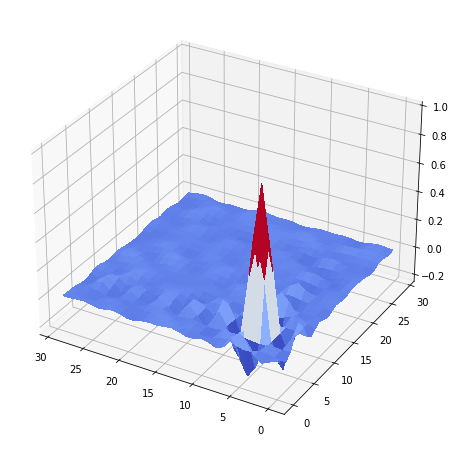

In [7]:
# Generate 2D map
# Reformat node ids - linear array of ids and array of coordinates for searching
 #12,2,63,71,83,86
X = 2 * np.pi * np.random.rand(1, d) # random angles
X = 1 * np.exp(1j * X) # create a phasor vector

Y = 2 * np.pi * np.random.rand(1, d) # random angles
Y = 1 * np.exp(1j * Y) # create a phasor vector
# print(X==Y)

HDind = np.zeros((nodes_tot, d), np.cfloat)
HDind_coord = np.zeros((nodes_tot, 2), float)
HDindReverse={}
cnt = 0
for i in range(nodes):
    for j in range(nodes):
        
#         tmp = circular_convolution(power(X, (sim_nodes * i)) , power(Y, (sim_nodes * j)))

        tmp = np.power(X, (sim_nodes * i)) * np.power(Y, (sim_nodes * j))
#         tmp/=norm(tmp)

#         tmp = power(X, (sim_nodes * i)) * power(Y, (sim_nodes * j))
        HDind[cnt] = tmp;
        HDind_coord[cnt][0] = i
        HDind_coord[cnt][1] = j
        HDindReverse[(i,j)]=cnt
        cnt += 1
# Visualize results for similarity between the nodes

DIST = np.zeros((nodes, nodes));
point = [5, 5]; # point of focus for visualization
ind = np.nonzero([np.all(val == point) for val in HDind_coord]); 
# print(ind)
# dp = np.real(np.matmul(HDind, np.conj(HDind[ind]).T)) / d; # cosine similarity between hypervectors of nodes 
# print(HDind[ind])
cnt = 0;
for i in range(nodes):
    for j in range(nodes):
        DIST[i][j] = cosineSimiliraty(HDind[ind][0],HDind[HDindReverse[(i,j)]])
        cnt += 1
    
surf_plot(DIST)

In [8]:
bmuInds=[]
for i in range(2,nodes,4):
    for j in range(2,nodes,4):
        bmuInds.append(HDindReverse[(i,j)])
# bmuInds
np.random.shuffle(bmuInds)

In [9]:
import seaborn as sn
import pandas as pd
# ssss=set()
def train(SOM,TR_perm,TR_L_perm,bmuInds,num_of_classes,numSOMs):
    jj=0
    ## number of iterations (Actually number of updates)
#     itr=int(num_of_classes*1) #+(num_of_classes*2//3)
    itr=1;
    while(itr*numSOMs<num_of_classes):
        itr+=1
    itr=(itr*numSOMs)+numSOMs

    beta=1
    while(jj<itr):
        size_observe=(jj+1)*3
        ind_shuffled1 = np.random.permutation(len(TR_perm))

        arr=[]
        meanDist=[]
        for j in range(size_observe):
            ## pick a random sample from training set
            hd_new=TR_perm[ind_shuffled1[j]]
            maxiValues=[]
            for kk in range(numSOMs):
                
                Ibmu1 = [SOM[kk]]* np.conj(hd_new)
                ### find the best matching ind
                dist1= 1-distance.cdist(Ibmu1,HDind, 'cosine')
                ## maxi is the maximum similarity for the random sample

                maxi1, bmu_ind1 = np.max(dist1), np.argmax(dist1)
                maxiValues.append(maxi1)
            
            
            
#             print(maxi1,maxi2)
            ### store the similarity as well as random sample index 
            arr.append([max(maxiValues),ind_shuffled1[j]])
#             meanDist.append(maxi)
#         MEAN=np.array(meanDist).mean()

        arr=sorted(arr)
#         ### Select BMU - sample with the minium similarity in the current  subset for the given iteration
        ID =  arr[0][1]
        HD_NEW =TR_perm[ID]

        bmu_ind = bmuInds[jj]# np.random.randint(0, 10000)

        delta = HDind[bmu_ind] * HD_NEW
        SOM[jj%numSOMs] = SOM[jj%numSOMs] + delta #*0.4
        
        jj+=1
#         print(TR_L_perm[ID])
#         ssss.add(TR_L_perm[ID])
#         print()
    return SOM
def label(SOM,TR_perm,TR_L_perm,nodes,HDind_coord,numOfClasses,it,numSOMs):
    labelMap={}
    for k in range(len(TR_perm)):
        hd_new = TR_perm[k, :];
        #Ibmu - hypervector for Index of Best Matching Unit
        maxiValues=[]
        bmus=[]
        for kk in range(numSOMs):
            
            
            Ibmu1 = [SOM[kk]] * np.conj(hd_new); 
            dist1= 1-distance.cdist(Ibmu1,HDind, 'cosine')
            maxi1, bmu_ind1 = np.max(dist1), np.argmax(dist1)
            maxiValues.append(maxi1)
            bmus.append(bmu_ind1)
        maxiValues=np.array(maxiValues)
        bmu_ind = bmus[np.argmax(maxiValues)]
        
        inds= (HDind_coord[bmu_ind][0],HDind_coord[bmu_ind][1])
        if(inds in labelMap):
            labelMap[inds].append(TR_L_perm[k])
        else:
            labelMap[inds]=[TR_L_perm[k]]
#     labelMap={}
    for i in labelMap:
        a = np.array(labelMap[i])
        counts = np.bincount(a)
        labelMap[i]=np.argmax(counts)
    hmappAll = np.zeros((nodes, nodes), int)
    for x in labelMap:
        hmappAll[int(x[0])][int(x[1])]=labelMap[x]
    labelIndexList=[]
    for i in labelMap:
        labelIndexList.append(HDindReverse[i])
    return [labelMap,labelIndexList]
def test(SOM,TS_D_perm,TS_L_perm,labelMap,numOfClasses,it,nodes,neighbourhood,hitList,labelIndexList,numSOMs):   
    ITER = np.zeros((numOfClasses,numOfClasses)) 
    for k in range(len(TS_D_perm)):
        hd_new = TS_D_perm[k, :];
        #Ibmu - hypervector for Index of Best Matching Unit
        
        maxiValues=[]
        bmus=[]
        for kk in range(numSOMs):
            
            
            Ibmu1 = [SOM[kk]] * np.conj(hd_new); 
            dist1= 1-distance.cdist(Ibmu1,hitList, 'cosine')
            maxi1, bmu_ind1 = np.max(dist1), labelIndexList[np.argmax(dist1)]
            maxiValues.append(maxi1)
            bmus.append(bmu_ind1)
        maxiValues=np.array(maxiValues)
        bmu_ind = bmus[np.argmax(maxiValues)]
        
        
        inds= (HDind_coord[bmu_ind][0],HDind_coord[bmu_ind][1])
        if(inds in labelMap):
#             print(labelMap[inds],TS_L_perm[k])
            ITER[TS_L_perm[k]-1][labelMap[inds]-1]+=1
        else:
            assert(1==0)

            
    df_cm = pd.DataFrame(ITER, index = [i for i in map(str,range(1,numOfClasses+1))],
              columns = [i for i in map(str,range(1,numOfClasses+1))])
    accuracy = sum([ITER[i][i] for i in range(numOfClasses)])/len(TS_D_perm)
    
    return   [ITER ,     accuracy]  

In [ ]:
from numpy.linalg import norm
import numpy as np
from sklearn.model_selection import KFold

from csv import writer
def append_list_as_row(file_name, list_of_elem):
    # Open file in append mode
    with open(file_name, 'a+', newline='') as write_obj:
        # Create a writer object from csv module
        csv_writer = writer(write_obj)
        # Add contents of list as last row in the csv file
        csv_writer.writerow(list_of_elem) 
neighbourhood=3
header = ["# of SOMs", '# of classes', 'It-1', 'It-2', 'It-3', 'It-4', 'It-5', 'It-6', 'It-7', 'It-8']

append_list_as_row('Results/results10000_variable_SOM_numSomVSacc_5000D_3gram.csv', header)

    
def cosineSimiliraty(a,b):
    return np.dot(a, np.conj(b))/(norm(a)*norm(b))

for numSOMs in  [1,5,10,15,21]: #range(1, 11):
#     np.random.seed(15)
    # SOM = np.zeros((1,d)) #1 * np.exp(1j * (2 * np.pi * np.random.rand(1, d))) # random initialization of the hypervector of SOM state
    SOM_2 = 1 * np.exp(1j * (2 * np.pi * np.random.rand(numSOMs, d))) # random initialization of the hypervector of SOM state
    [rho,theta] = R2P(SOM_2);        
    SOM_2 = 1 * np.exp(1j *theta)
    SOM_SAVED_2 = SOM_2.copy()
   
    
    for numOfClasses in  range(21,22):

        D_TMP = TR_D.copy()[:samplesPerClass*numOfClasses] #np.concatenate((class1, class2,class3,class4,class5), axis = 0)
        L_PERM = np.concatenate(([[i]*samplesPerClass for i in range(1,numOfClasses+1)]), axis = 0)

        D_T_TMP = TS_D.copy()[:(samplesPerClass//2)*numOfClasses] #np.concatenate((class1, class2,class3,class4,class5), axis = 0)
        L_T_PERM = np.concatenate(([[i]*(samplesPerClass//2) for i in range(1,numOfClasses+1)]), axis = 0)

        kf = KFold(n_splits=5,shuffle=True)
        it=1
        accs=[]
        for i in range(8):
            inds1=np.random.permutation(len(D_TMP))
            inds2=np.random.permutation(len(D_T_TMP))
            TR_perm,TR_L_perm=D_TMP[inds1],L_PERM[inds1]
            TS_D_perm,TS_L_perm=D_T_TMP[inds2],L_T_PERM[inds2]
            SOM_2 = SOM_SAVED_2.copy()
            SOM_2 =train(SOM_2,TR_perm,TR_L_perm,bmuInds,numOfClasses,numSOMs)
            labelMap,labelIndexList = label(SOM_2,TR_perm,TR_L_perm,nodes,HDind_coord,numOfClasses,it,numSOMs)
            hitList = [HDind[j] for j in labelIndexList]
            ITER,acc =test(SOM_2,TS_D_perm,TS_L_perm,labelMap,numOfClasses,it,nodes,neighbourhood,hitList,labelIndexList,numSOMs)
            accs.append([acc,it])
    #         break
            it+=1
        accss=[iii[0] for iii in accs]
        accs =sorted(accs)
        print("Number of SOMs, ",numSOMs," Mean accuracy", np.array(accss).mean())  
        data=[numSOMs,numOfClasses]+accss
        append_list_as_row('Results/results10000_variable_SOM_numSomVSacc_5000D_3gram.csv', data)
  

C:\Users\HyperSeed\anaconda3\envs\phd\lib\site-packages\numpy\core\_asarray.py:177: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order='C', ndmin=1)


Number of SOMs,  1  Mean accuracy 0.6327380952380952


In [ ]:
import pandas as pd
df= pd.read_csv("Results/results10000_variable_SOM_numSomVSacc_5000D_3gram.csv")

In [ ]:
D=df.to_dict(orient='records')

In [ ]:
dic={}
for i in range(len(D)):
    dic[int(D[i]['# of SOMs'])]=[]
    for j in range(1,9):
        dic[int(D[i]['# of SOMs'])].append(D[i]["It-"+str(j)])
    dic[int(D[i]['# of SOMs'])]=np.array(dic[int(D[i]['# of SOMs'])]).astype('float64')
df1=pd.DataFrame(dic)
df1.quantile(q=[0.25, 0.5, 0.75], axis=0, numeric_only=True, interpolation='midpoint')
df2=df1.describe()
labels = list(df2.columns)

# create dictionaries for each column as items of a list
bxp_stats = df2.apply(lambda x: {'med':x["50%"], 'q1':x["25%"], 'q3':x["75%"], 'whislo':x['min'], 'whishi':x['max']}, axis=0).tolist()


In [ ]:
for index, item in enumerate(bxp_stats):
    item.update({'label':labels[index]})

_, ax = plt.subplots(figsize=(10,8))
ax.bxp(bxp_stats, showfliers=False);
y_ticks= np.array([0.1 +0.1*x for x in range(10)])
y_ticks = np.append(y_ticks, 0.97)

# Set xtick locations to the values of the array `x_ticks`
ax.set_yticks(y_ticks)
ax.set_ylim([0.5, 1.01])

plt.xlabel('Number of seed vectors', fontsize=15)
plt.ylabel('Accuracy', 
           fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axhline(y=0.97, color='r', linestyle='dotted')
plt.show()